In [219]:
# Import Libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import sklearn 
import scipy
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

#Classifier Libraries
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

#SKLearn Libraries
from scipy.stats import mstats
from imblearn.over_sampling import SMOTE 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Other Libraries
import warnings
warnings.filterwarnings("ignore")

# Workflow Summary
#### Objective 
* The primary objective of the loyalty model is to predict a customer’s propensity to join a loyalty program. 
* As such, I built a binary classification model with two possible outcomes: Loyalty or Non-loyalty customers.

#### Data Cleaning/Visualization
* First, I explored the data set to understand its features and conducted data cleaning to convert object features to categorical ones.  
* Next, I performed data visualization to compare numerical features to the Loyalty outcome variable. I also, investigated interaction effects between the gender feature and other numerical features. 

#### Feature Engineering/Model Prep
* The next step was to perform featuring engineering where I was able to (1) encode categorical features (2) investigate feature correlations and (3) scale all numerical features. 
* After this, I began to prep the dataset for modeling. Here, I noticed that the outcome variable was greatly overbalanced with 83% Non-loyalty customers. To fix this, I oversampled the minority class (Loyalty customers) to obtained a balanced y label.

#### Build Models
* With the dataset ready for modeling, I used logistic regression to obtain a baseline model performance, which resulted in 79.7% accuracy score on the test dataset. 
* Next, I ran six other classifier models, with the Random Forest classifier performing the best with a score of 89.2%. 
* Lastly, I utilized a voting classifier Ensemble model obtaining a accuracy score of 87.8% My next step was to evaluate the Random Forest and the Ensemble models. 

#### Model Evaluation
* I plotted the confusion matrix for each, along with printing the classification report. The Random Forest model seemed to perform more consistently across classes, whereas the Ensemble model displayed larger discrepancies in Type I and II error (confusion matrix) and recall scores (classification report). 
* Upon performing cross validation on both models, I realized that neither model was overfitting, and that the Ensemble model had a slightly higher accuracy score across folds compared to the Random Forest model. 

#### Optimize Winning Model
* Nonetheless, I chose the Random Forest model as the winning model given that it performed more consistently across classes. 
* In the last step of my analysis, I optimized the Random Forest model using grid search, improving model accuracy to 90%.

# Data Exploration

In [196]:
#Make Sense of Data
path = '/Users/mac/Dropbox/Thinkful_Coursework/Course/Take_Home/customers_data.csv'
df = pd.read_csv(path)
df.head()

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


In [197]:
# Number of rows and columns
x = 93
print('Shape of dataframe')
print('-' *x)
print('No. of Rows:', df.shape[0])
print('No. of Columns:', df.shape[1])
print('-' *x)

# Check data types
print('Column Data Types')
print('-' *x)
print(df.dtypes)
print('-' *x)

# Check for missing data
print('Missing Data in Dataframe')
print('-' *x)
print(df.isnull().sum().sort_values(ascending=False))
print('-' *x)

# Check for outliers
print('Column Summary')
print('-' *x)
df.describe().transpose()

Shape of dataframe
---------------------------------------------------------------------------------------------
No. of Rows: 120000
No. of Columns: 7
---------------------------------------------------------------------------------------------
Column Data Types
---------------------------------------------------------------------------------------------
Unnamed: 0                 int64
purch_amt                float64
gender                    object
card_on_file              object
age                      float64
days_since_last_purch    float64
loyalty                     bool
dtype: object
---------------------------------------------------------------------------------------------
Missing Data in Dataframe
---------------------------------------------------------------------------------------------
loyalty                  0
days_since_last_purch    0
age                      0
card_on_file             0
gender                   0
purch_amt                0
Unnamed: 0            

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120000.0,59999.500000,34641.160489,0.00,29999.75,59999.50,89999.25,119999.0
purch_amt,120000.0,44.036234,20.473148,-43.95,30.21,43.97,57.83,142.2
age,120000.0,25.803008,10.153072,-22.00,19.00,26.00,33.00,71.0
days_since_last_purch,120000.0,56.605908,16.422187,-9.00,45.00,57.00,68.00,125.0


# Data Cleaning

In [198]:
# Convert object columns to categorical variables
object_cols = df.select_dtypes(['object']).columns.tolist()

for cols in object_cols:
    df[cols] = df[cols].astype('category')

In [199]:
# Recheck data types
print('Column Data Types')
print('-' *x)
print(df.dtypes)
print('-' *x)

Column Data Types
---------------------------------------------------------------------------------------------
Unnamed: 0                  int64
purch_amt                 float64
gender                   category
card_on_file             category
age                       float64
days_since_last_purch     float64
loyalty                      bool
dtype: object
---------------------------------------------------------------------------------------------


In [200]:
#Drop extra index from datafrmame
df = df[['purch_amt','gender','card_on_file','age','days_since_last_purch','loyalty']]
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,male,no,31.0,35.0,False
1,65.16,male,yes,23.0,61.0,False
2,40.60,female,no,36.0,49.0,False
3,38.01,male,yes,47.0,57.0,False
4,22.32,female,yes,5.0,39.0,False


# Data Visualization

## Numerical Features vs. Loyalty

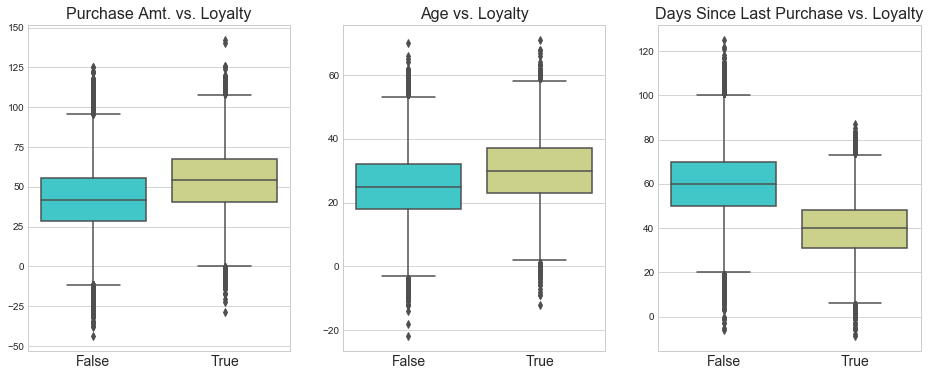

In [201]:
labels = ['False','True']

# Suplots of Numerical Features vs Loyalty
sns.set_style('whitegrid')
f, axes = plt.subplots(1,3, figsize = (16,6))

# Plot Purchase Amount vs. Loyalty
sns.boxplot(data = df, x = 'loyalty', y = 'purch_amt', palette ='rainbow', ax = axes[0])
axes[0].set_xlabel('', fontsize=14)
axes[0].set_xticklabels(labels, fontsize=14)
axes[0].set_ylabel('', fontsize=14)
axes[0].set_title('Purchase Amt. vs. Loyalty', fontsize=16)

# Plot Age vs. Loyalty
sns.boxplot(x = 'loyalty', y = 'age', data = df, palette ='rainbow', ax = axes[1])
axes[1].set_xlabel('', fontsize=14)
axes[1].set_xticklabels(labels, fontsize=14)
axes[1].set_ylabel('',fontsize=14)
axes[1].set_title('Age vs. Loyalty',fontsize=16)

# Plot Days Since Last Purchase vs. Loyalty
sns.boxplot(x = 'loyalty', y = 'days_since_last_purch', data = df, palette = 'rainbow', ax = axes[2])
axes[2].set_xlabel('', fontsize=14)
axes[2].set_xticklabels(labels, fontsize=14)
axes[2].set_ylabel('',fontsize=14)
axes[2].set_title('Days Since Last Purchase vs. Loyalty',fontsize=16)

plt.show()

## Numerical Features vs. Gender

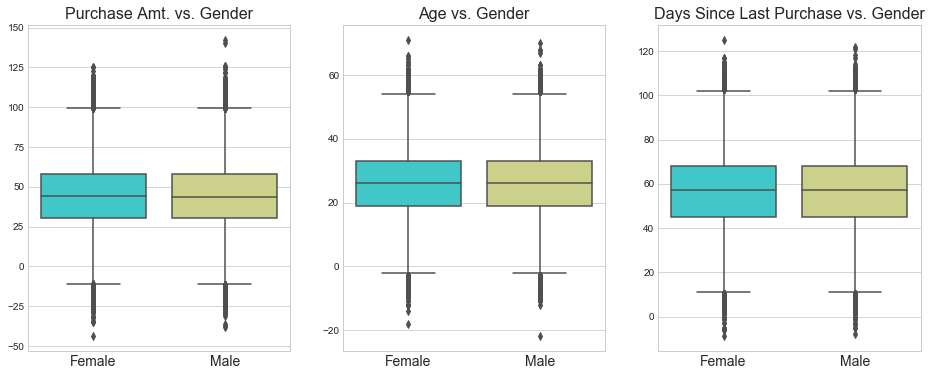

In [202]:
labels = ['Female','Male']

# Suplots of Numerical Features vs Gender
sns.set_style('whitegrid')
f, axes = plt.subplots(1,3, figsize = (16,6))

# Plot Purchase Amount vs. Gender
sns.boxplot(data = df, x = 'gender', y = 'purch_amt', palette ='rainbow', ax = axes[0])
axes[0].set_xlabel('', fontsize=14)
axes[0].set_xticklabels(labels, fontsize=14)
axes[0].set_ylabel('', fontsize=14)
axes[0].set_title('Purchase Amt. vs. Gender', fontsize=16)

# Plot Age vs. Gender
sns.boxplot(x = 'gender', y = 'age', data = df, palette ='rainbow', ax = axes[1])
axes[1].set_xlabel('', fontsize=14)
axes[1].set_xticklabels(labels, fontsize=14)
axes[1].set_ylabel('',fontsize=14)
axes[1].set_title('Age vs. Gender',fontsize=16)

# Plot Days Since Last Purchase vs. Gender
sns.boxplot(x = 'gender', y = 'days_since_last_purch', data = df, palette = 'rainbow', ax = axes[2])
axes[2].set_xlabel('', fontsize=14)
axes[2].set_xticklabels(labels, fontsize=14)
axes[2].set_ylabel('',fontsize=14)
axes[2].set_title('Days Since Last Purchase vs. Gender',fontsize=16)

plt.show()

# Feature Engineering

## Modify Data Types

In [203]:
from sklearn.preprocessing import LabelEncoder

#Encode categorical features to prepare model
df_encode = df.copy()
lb_make = LabelEncoder()

df_encode['gender'] = lb_make.fit_transform(df['gender'])
df_encode['card_on_file'] = lb_make.fit_transform(df['card_on_file'])
df_encode['loyalty'] = lb_make.fit_transform(df['loyalty'])

df_encode.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,1,0,31.0,35.0,0
1,65.16,1,1,23.0,61.0,0
2,40.60,0,0,36.0,49.0,0
3,38.01,1,1,47.0,57.0,0
4,22.32,0,1,5.0,39.0,0


## Review Feature Correlation

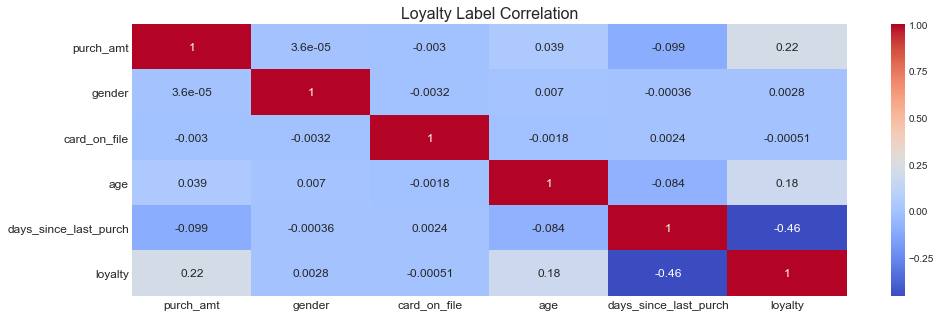

In [204]:
#Create correlation plot
plt.figure(figsize=(16,5))

corr = df_encode.corr()
sns.heatmap(corr, cmap='coolwarm', annot= True, annot_kws={"size": 12})
plt.title('Loyalty Label Correlation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Scale Numeric Features

In [205]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df_encode['scaled_purch_amt'] = rob_scaler.fit_transform(df_encode['purch_amt'].values.reshape(-1,1))
df_encode['scaled_age'] = rob_scaler.fit_transform(df_encode['age'].values.reshape(-1,1))
df_encode['scaled_days_last_purch'] = rob_scaler.fit_transform(df_encode['days_since_last_purch'].values.reshape(-1,1))

#Drop Original Features
df_encode.drop(['purch_amt','age', 'days_since_last_purch'], axis=1, inplace=True)

df_encode.head()

,gender,card_on_file,loyalty,scaled_purch_amt,scaled_age,scaled_days_last_purch
0,1,0,0,-0.883056,0.357143,-0.956522
1,1,1,0,0.767198,-0.214286,0.173913
2,0,0,0,-0.122013,0.714286,-0.347826
3,1,1,0,-0.215786,1.500000,0.000000
4,0,1,0,-0.783852,-1.500000,-0.782609


# Model Prep

## Check Balance of Outcome Label

In [206]:
x=115
print('-' *x)
print('False is', round(df_encode['loyalty'].value_counts()[0]/len(df_encode) * 100,1), '% of the dataset')
print('True is', round(df_encode['loyalty'].value_counts()[1]/len(df_encode) * 100,1), '% of the dataset')
print('-' *x)
print('No. of False rows is ', round(df_encode['loyalty'].value_counts()[0]))
print('No. of True rows is ', round(df_encode['loyalty'].value_counts()[1]))
print('-' *x)

-------------------------------------------------------------------------------------------------------------------
False is 83.3 % of the dataset
True is 16.7 % of the dataset
-------------------------------------------------------------------------------------------------------------------
No. of False rows is  100000
No. of True rows is  20000
-------------------------------------------------------------------------------------------------------------------


## Oversample Minority Class

In [207]:
X = df_encode.drop('loyalty', axis=1)
y = df['loyalty']

#Use Oversample to manage unbalanced dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)

#Create balanced dataframe
balanced_df = pd.DataFrame(X_res)
balanced_df['Class'] = y_res

#Check to see if classes are now balanced
pd.DataFrame(y_res)[0].value_counts()

True     100000
False    100000
Name: 0, dtype: int64

## Split Training and Test Data Sets

In [208]:
#Split Training and Test Sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Run Models

## Baseline Model

In [217]:
#Fit Logistic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train)

#Determine Logisitic Regression Score
print('Logistic Regression:', round(lr.score(X_test, y_test) * 100,2),'%')

#Create Logsitic Regression Confusion Matrix
y_pred = lr.predict(X_test)
confusion_matrix(y_test, y_pred)

Logistic Regression: 79.77 %


array([[15706,  4194],
       [ 3899, 16201]])

## Other Classifier Models

In [218]:
#Define Classifier Models
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier()
rig = RidgeClassifier() 
clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

#Fit Classifier Models
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)
dtc.fit(X_train, y_train)
knn.fit(X_train, y_train)
rig.fit(X_train, y_train)
clf.fit(X_train, y_train)

#Get Classifier Accuracies
print('1.) Random Forest:', round(rf.score(X_test, y_test) * 100,2),'%')
print('2.) Gradient Boosting:', round(gb.score(X_test, y_test) * 100,2),'%')
print('3.) Decision Tree:', round(dtc.score(X_test, y_test) * 100,2),'%')
print('4.) KNeighbors:', round(knn.score(X_test, y_test) * 100,2),'%')
print('5.) Ridge:', round(rig.score(X_test,y_test) *100,2),'%')
print('6.) XGBoost:', round(clf.score(X_test,y_test) *100,2),'%')

1.) Random Forest: 89.18 %
2.) Gradient Boosting: 82.64 %
3.) Decision Tree: 87.43 %
4.) KNeighbors: 84.91 %
5.) Ridge: 79.83 %
6.) XGBoost: 84.09 %


## Ensemble Model

In [220]:
#Setup Voting Classifer with Top 5 Models
vc = VotingClassifier(estimators=[('rf', rf), ('gb', gb),('dtc',dtc) ,('knn',knn),('clf', clf)], voting='hard')
vc.fit(X_train, y_train)
print('Voting Classifer: ', round(vc.score(X_test,y_test) *100,2),'%')

Voting Classifer:  87.83 %


# Model Evaluation

## Confusion Matrix

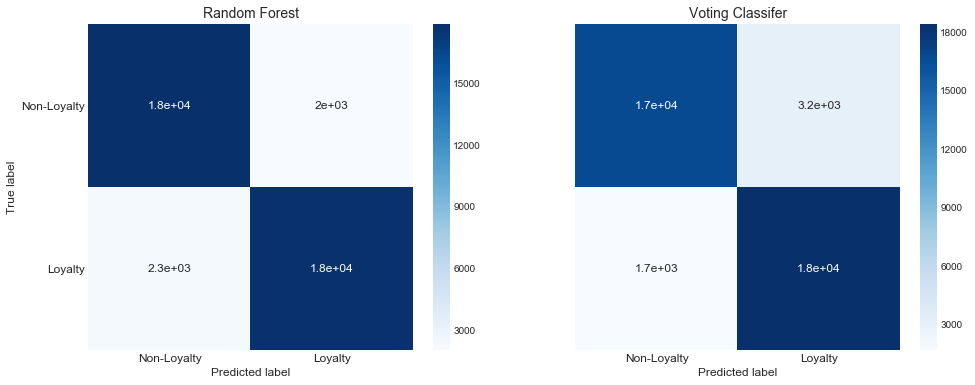

In [228]:
#Get y_pred top model and ensemble model
y_pred_rf = rf.predict(X_test)
y_pred_vc = vc.predict(X_test)

#Get confusion matrix top model and ensemble model
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_vc = confusion_matrix(y_test, y_pred_vc)

#Setup Confusion Matrix Plots
fig, ax = plt.subplots(1, 2,figsize=(16,6))

#Random Forest Confusion Matrix
sns.heatmap(cm_rf, ax=ax[0], annot=True, annot_kws={"size": 12}, cmap=plt.cm.Blues)
ax[0].set_title("Random Forest", fontsize=14)
ax[0].set_xticklabels(['Non-Loyalty', 'Loyalty'], fontsize=12)
ax[0].set_yticklabels(['Non-Loyalty', 'Loyalty'], fontsize=12, rotation=360)
ax[0].set_xlabel('Predicted label', fontsize=12)
ax[0].set_ylabel('True label', fontsize=12)

#Voting Classifer Model Confusion Matrix
sns.heatmap(cm_vc , ax=ax[1], annot=True, annot_kws={"size": 12}, cmap=plt.cm.Blues)
ax[1].set_title("Voting Classifer", fontsize=14)
ax[1].set_xticklabels(['Non-Loyalty', 'Loyalty'], fontsize=12, rotation=360)
ax[1].set_xlabel('Predicted label', fontsize=12)
ax[1].set_yticklabels(['', ''], fontsize=12, rotation=360)

plt.show()

## Classification Reports

In [229]:
print ('\nClassification Report: Random Forrest\n', classification_report(y_test, y_pred_rf))
print('__' *28)
print ('\nClassification Report: Voting Classifer\n', classification_report(y_test, y_pred_vc))
print('__' *28)


Classification Report: Random Forrest
              precision    recall  f1-score   support

      False       0.89      0.90      0.89     19900
       True       0.90      0.88      0.89     20100

avg / total       0.89      0.89      0.89     40000

________________________________________________________

Classification Report: Voting Classifer
              precision    recall  f1-score   support

      False       0.91      0.84      0.87     19900
       True       0.85      0.92      0.88     20100

avg / total       0.88      0.88      0.88     40000

________________________________________________________


## Cross Validation

In [242]:
from sklearn.model_selection import cross_val_score
print('Random Forest:\n', cross_val_score(rf, X_test, y_test, cv=6))
print('__' *34)
print('Voting Classifier:\n', cross_val_score(vc, X_test, y_test, cv=6))

Random Forest:
 [0.83845808 0.83980801 0.83230838 0.83485826 0.83933393 0.8420342 ]
____________________________________________________________________
Voting Classifier:
 [0.84775761 0.84985751 0.84760762 0.84655767 0.85523552 0.84428443]


# Optimize Model Performance: Random Forest

In [245]:
from sklearn.grid_search import GridSearchCV
 
rf = RandomForestClassifier(n_jobs=-1, max_features='sqrt', oob_score = True) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [9, 27, 54,],
           "max_depth" : [1, 10, 20, 30],
           "min_samples_leaf" : [1, 4, 8]}
 
cv_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
cv_rf.fit(X_train, y_train)
print (cv_rf.best_params_)

{'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 54}


In [249]:
# Optimized RF classifier
rf = RandomForestClassifier(n_estimators=54, max_depth=30, max_features='sqrt', min_samples_leaf = 1)

#Fit Classifier Models
rf.fit(X_train, y_train)

#Get Classifier Accuracies
print('Random Forest:', round(rf.score(X_test, y_test) * 100,2),'%')

Random Forest: 90.02 %


In [250]:
from sklearn.model_selection import cross_val_score
print('Random Forest:\n', cross_val_score(rf, X_test, y_test, cv=6))

Random Forest:
 [0.84955752 0.85570721 0.85420729 0.84730763 0.86168617 0.85508551]
